# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [110]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')

In [2]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')

In [112]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

(891221, 85)

In [113]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [114]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [115]:
feat_info.head(50)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [116]:
feat_info.shape

(85, 4)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [117]:
# Identify missing or unknown data values and convert them to NaNs.
# Define useful functions
def dict_transform(value):
    if str(value) in str(mapping_dict[col]):
        return np.nan
    else:
        return value

def various_to_int(values):
    new_list = []
    for value in values:
        try:
            new_list.append(int(value))
        except:
            new_list.append(value)
    return new_list

In [118]:
# Create dictionary to map missing values
feature_list_azdias = [feature for feature in azdias.columns]
feature_list_info = list(feat_info['attribute'])

# Assert, that the order of features is the same in both lists
assert np.sum([feature1 == feature2 for feature1,feature2 in zip(feature_list_azdias,feature_list_info)]) == len(feature_list_azdias)

# Map missing values
mapping_values = [various_to_int(values[1:-1].split(',')) for values in feat_info['missing_or_unknown']]
mapping_dict = dict(zip(feature_list_azdias,mapping_values))

for col in azdias.columns:
    azdias[col] = azdias[col].map(dict_transform)

In [119]:
# Check if all values were correctly encoded
counter = 0
for col in azdias.columns:
    for value in azdias[col]:
        if value in mapping_dict[col]:
            counter+=1
    
print(counter)

1844863


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

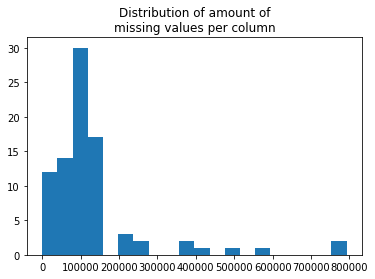

In [120]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_dist = np.array([azdias[col].isnull().sum() for col in azdias.columns])

_ = plt.hist(missing_dist,bins=20)
_ = plt.title('Distribution of amount of\nmissing values per column')
plt.show()

In [121]:
# Classify features
outlier_missing = [col for col in azdias.columns if azdias[col].isnull().sum() > 200000]
few_missing = [col for col in azdias.columns if azdias[col].isnull().sum() <= 200000 and azdias[col].isnull().sum() > 0]
no_missing = [col for col in azdias.columns if azdias[col].isnull().sum() == 0]

In [122]:
# Investigate patterns in the amount of missing data in each column.
# Create missing data report do investigate one column ata time

missing_data_report = azdias.drop(outlier_missing,axis=1).isnull().sum().sort_values(ascending=False)
missing_data_report = missing_data_report.loc[missing_data_report != 0]
missing_data_report

FINANZTYP                199572
ALTERSKATEGORIE_GROB     145768
FINANZ_HAUSBAUER         143104
FINANZ_MINIMALIST        139587
CAMEO_DEUG_2015          135564
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
KBA05_ANTG4              133324
KBA05_BAUMAX             133324
KBA05_GBZ                133324
PRAEGENDE_JUGENDJAHRE    129446
SEMIO_KULT               128216
ZABEOTYP                 123622
REGIOTYP                 121196
KKK                      121196
SEMIO_VERT               120437
PLZ8_BAUMAX              116515
PLZ8_ANTG1               116515
PLZ8_ANTG2               116515
PLZ8_ANTG3               116515
PLZ8_ANTG4               116515
PLZ8_HHZ                 116515
PLZ8_GBZ                 116515
SEMIO_LUST               110382
SEMIO_REL                108130
W_KEIT_KIND_HH           107602
KBA13_ANZAHL_PKW         105800
FINANZ_VORSORGER         104369
                          ...  
GEBAEUDE

In [123]:
# Investigate missing data by column one by one
# Given the above report, it is obvious, that columns which include region level/ PLZ8 level information contain an above
# average amount of NaNs.
region_pattern1 = 'KBA.*?'
region_pattern2 = 'PLZ8_.*?'
region_level_variables = [col for col in few_missing if re.match(region_pattern1,col) or re.match(region_pattern2,col)]
region_level_variables.append('MOBI_REGIO')
region_level_variables.append('REGIOTYP')

azdias.loc[azdias['KKK'].isnull(),region_level_variables]

,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,MOBI_REGIO,REGIOTYP
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,NaN,NaN,486.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,1.0,0.0,0.0,0.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From the above table one can see, that in rows, where KKK is NaN, the other region variables also tend to be NaN. This can
be an indicator that these people's region is unknown.

Furthermore, it is apparent, that the subcategory (indicated by 'FEIN') NaN when the supercategory (indicated by 'GROB') is NaN, but not vice versa.

The following cells are meant to show, that there are certain groups of features, which do imply each others' NaNs. Meaning, that if one of the features is NaN for a given observations, all of the features are NaN for that observation.

In [124]:
# One could also assume, that the 'Cameo' variables are always NaN togehter.
azdias.loc[azdias['CAMEO_INTL_2015'].isnull(),['CAMEO_DEU_2015','CAMEO_DEUG_2015']].notnull().sum()

CAMEO_DEU_2015     0
CAMEO_DEUG_2015    0
dtype: int64

In [125]:
# There are also other features, that seem to always be NaN together, however, the logic relationship is not always clear
azdias.loc[azdias['HEALTH_TYP'].isnull(),['SHOPPER_TYP','VERS_TYP']].sum()

SHOPPER_TYP    194268.0
VERS_TYP       122418.0
dtype: float64

In [126]:
# In a lot of cases, the genral living conditions of a household are unknown
azdias.loc[azdias['CJT_GESAMTTYP'].isnull(),['GFK_URLAUBERTYP','RETOURTYP_BK_S','ONLINE_AFFINITAET','LP_STATUS_FEIN','LP_STATUS_GROB']].notnull().sum()

GFK_URLAUBERTYP      0
RETOURTYP_BK_S       0
ONLINE_AFFINITAET    0
LP_STATUS_FEIN       0
LP_STATUS_GROB       0
dtype: int64

In [127]:
# It appears, that in some communities, unemployment is unknown. Therefore, relative unemplyoment is by definition also unknown
azdias.loc[azdias['ARBEIT'].isnull(),['RELAT_AB']].notnull().sum()

RELAT_AB    0
dtype: int64

In [128]:
# It appears, that sometimes, the exact location of a postcode-area is unknown, therefore, the distance to the next urban center
# the distance to the city center and the areas population density are unknown.
azdias.loc[azdias['INNENSTADT'].isnull(),['BALLRAUM','EWDICHTE']].notnull().sum()

BALLRAUM    0
EWDICHTE    0
dtype: int64

In [129]:
# The following features also imply each others NaNs. They indicate a lack of knowledge about the location, age
# and immeadiate neighborhood of the observed household.
azdias.loc[azdias['OST_WEST_KZ'].isnull(),['MIN_GEBAEUDEJAHR','WOHNLAGE','GEBAEUDETYP']].notnull().sum()

MIN_GEBAEUDEJAHR    0
WOHNLAGE            0
GEBAEUDETYP         0
dtype: int64

In [130]:
# The following features' NaNs indicate a lack of knowledge about the observed individual's family situation.
# They are also an example for how a NaN in a supercategory implies a NaN in the subcategory.
azdias.loc[azdias['LP_FAMILIE_GROB'].isnull(),['LP_FAMILIE_FEIN']].notnull().sum()

LP_FAMILIE_FEIN    0
dtype: int64

In [131]:
# The following features indicate a lack of information about the specific living conditions inside a household.
azdias.loc[azdias['ANZ_PERSONEN'].isnull(),['ANZ_TITEL','WOHNDAUER_2008','SOHO_KZ']].notnull().sum()

ANZ_TITEL         0
WOHNDAUER_2008    0
SOHO_KZ           0
dtype: int64

In [132]:
# The following features indicate a lack of knowedge about the specific individual's personal preferences,
# partly in regard to online shopping.
azdias.loc[azdias['CJT_GESAMTTYP'].isnull(),['GFK_URLAUBERTYP','RETOURTYP_BK_S','ONLINE_AFFINITAET','LP_STATUS_FEIN','LP_STATUS_GROB']].notnull().sum()

GFK_URLAUBERTYP      0
RETOURTYP_BK_S       0
ONLINE_AFFINITAET    0
LP_STATUS_FEIN       0
LP_STATUS_GROB       0
dtype: int64

In [133]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias = azdias.drop(outlier_missing,axis=1)

#### Discussion 1.1.2: Assess Missing Data in Each Column

It appears, that after converting the assigned values to np.nan, there are only a few features remaining without at least one missing values. However, the previous analysis has also shown, that there is a clear relationship between at least some of the missing values in one column, and the missing values in another column. One example herefore is AGER_TYP, as some people (the younger generation) can not be assigned label like "passsive elderly". Here, one would have to impute a "None" value, to indicate, that these specific observation are not part of the eligible universe of "elderly people".

Furthermore, there are variables, which are not applicable to most observations. Most noticeable example would be the feature "TITLE_KZ" the lack of values in that column could result from the fact, that most people in Germany do not hold an academic degree like Doktor or Professor. Therefore, one should impute the value "None", to indicate, that the respective observation does not have an academic degree. This notion is also supported by the fact, that there is no other TITLE_KZ label, that appears often enough to represent the broad population.

Also, there are clearly a few groups of features, where NaN values in one column imply NaN values in the other columns. Examples for these patterns have been provided above.

For now, the mentioned feature impuation possibilities will not be exploited, as it is part of this notebook, that columns, with a huge amount of missing data (>200000) are to be dropped for now.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [27]:
# How much data is missing in each row of the dataset?
azdias['missing_in_row'] = azdias.apply(lambda x: x.isnull().sum(),axis=1)

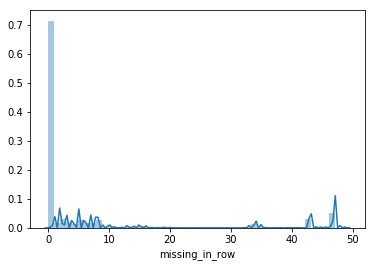

In [29]:
sns.distplot(a=azdias['missing_in_row'])

In [30]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 0

below_threshold = azdias.loc[azdias['missing_in_row']<=threshold,:].drop('missing_in_row',axis=1)
above_threshold = azdias.loc[azdias['missing_in_row']>threshold,:].drop('missing_in_row',axis=1)

print('Rows below threshold: {}'.format(below_threshold.shape[0]))
print('Rows above threshold: {}'.format(above_threshold.shape[0]))
print('Share of rows above threshold: {}'.format(above_threshold.shape[0]/(below_threshold.shape[0]+above_threshold.shape[0])))
print('Share of NaNs in rows below threshold: {}'.format(below_threshold.isnull().sum().sum()/below_threshold.size))
print('Share of NaNs in rows above threshold: {}'.format(above_threshold.isnull().sum().sum()/above_threshold.size))

Rows below threshold: 623209
Rows above threshold: 268012
Share of rows above threshold: 0.3007245116531141
Share of NaNs in rows below threshold: 0.0
Share of NaNs in rows above threshold: 0.23781780411494893


In [31]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def check_columns(rows_below_threshold,rows_above_threshold,column_list):
    rows_below_threshold = rows_below_threshold.isnull()
    rows_above_threshold = rows_above_threshold.isnull()
    
    n_columns = 2
    n_rows = len(column_list)
    fig,ax = plt.subplots(n_rows,n_columns,figsize=(25,100))
    
    for i,column in enumerate(column_list):
        sns.countplot(x=column,data=rows_below_threshold,ax=ax[i][0]).set_title(column)
        sns.countplot(x=column,data=rows_above_threshold,ax=ax[i][1]).set_title(column)
            
    # plt.tight_layout()        
    plt.show()

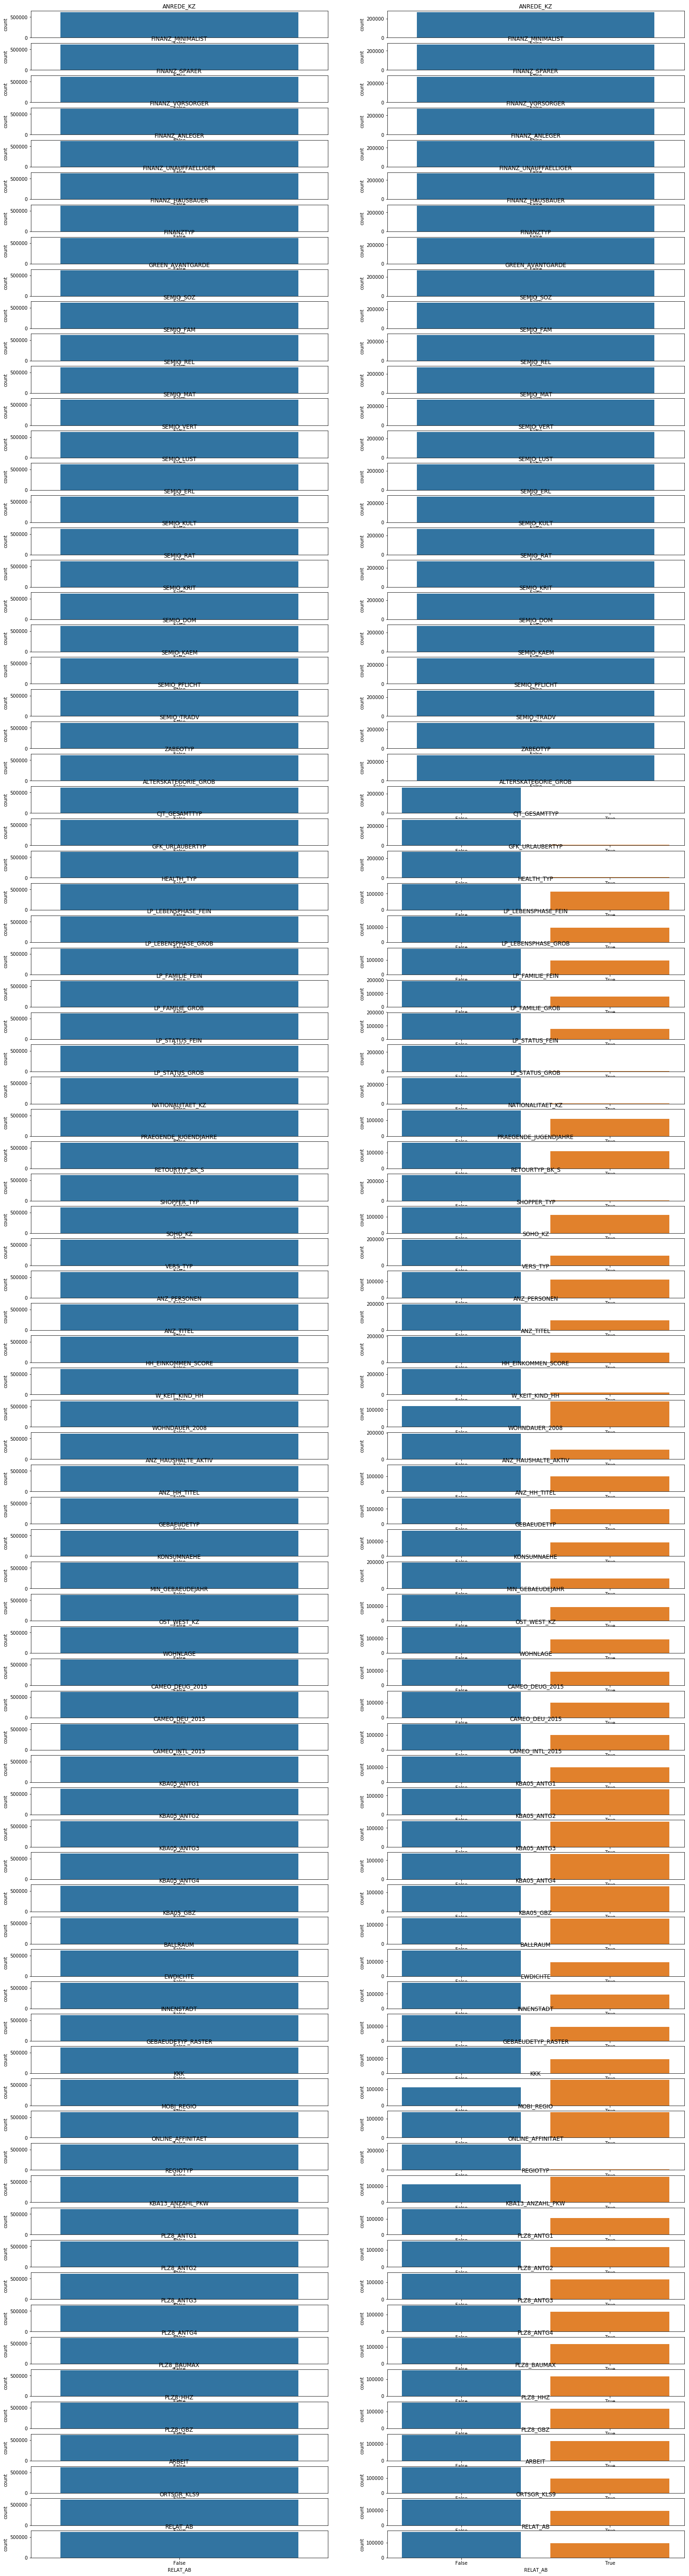

In [32]:
check_columns(below_threshold,above_threshold,no_missing+few_missing)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Well, as of now, the above plots are not easily readable, but it is clear, that the rows with an above-threshold amount of missing values have a tendency to have significantly more missing values in columns with otherwise very little amount of missing data. Therefore we can conclude, that missing values are very strongly overrepresented by outlier rows. These outlier rows represent about 12% of the remaining data, and contain 50% NaNs. If they were to be dropped, the remaining dataset would only contain abou 1.2% missing values.

EDIT: Since in the next step I have to use pd.get_dummies on the data, I (at least temporarily) had to remove all NaNs from the data, which is why in the above step, 30% of the data was dropped. I want to say, that I do not understand, I why I would start the selection and re-encoding step before imputing missing values. This is why I will later in the function only drop certain rows, which have a high amount of missing data, and will impute the rest with each column's mean or mode (depending on the feature type).

As instructed, I will only use the rows with less-than-threshold-missing values and drop the outlier_missing columns. Furthermore, I will save the resulting dataframe, so I can save time when closing and re-opening the notebook.

In [26]:
df = below_threshold
df.to_csv('azdias_processed.csv')

NameError: name 'below_threshold' is not defined

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [134]:
df = pd.read_csv('azdias_processed.csv')

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


24

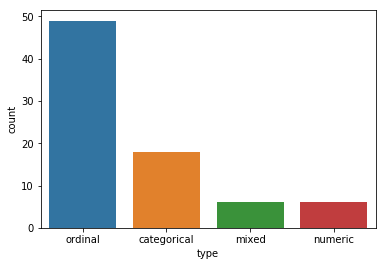

In [135]:
# How many features are there of each data type?
eligible = [col for col in df.columns]
clean_feat_info = feat_info.copy()
clean_feat_info.index = feat_info['attribute']
clean_feat_info = clean_feat_info.loc[eligible,:]
clean_feat_info.drop('attribute',axis=1,inplace=True)
sns.countplot(x='type',data=clean_feat_info)
number_of_categorical_mixed = clean_feat_info.loc[(clean_feat_info['type'] == 'categorical') | (clean_feat_info['type'] == 'mixed'),:].shape[0]
number_of_categorical_mixed

In [136]:
# Create list of numeric and non-numeric features for later use
numeric_features = [col for col in df.columns if clean_feat_info.loc[col,'type']=='numeric']
non_numeric_features = [col for col in df.columns if col not in numeric_features]

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [137]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
conversion_candidates = []
for index, value in feat_info.loc[:,['attribute','type']].iterrows():
    if value[1] == 'categorical' and value[0] in eligible and not (df[value[0]].dtype != 'object' and df[[value[0]]].nunique()[0]==2):
        conversion_candidates.append(value[0])

In [138]:
# Re-encode categorical variable(s) to be kept in the analysis.
print(df.shape)
df = pd.get_dummies(df,columns=conversion_candidates)
print(df.shape)

(623209, 80)
(623209, 193)


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623209 entries, 0 to 623208
Columns: 193 entries, Unnamed: 0 to CAMEO_DEU_2015_9E
dtypes: float64(42), int64(24), uint8(127)
memory usage: 389.3 MB


#### Discussion 1.2.1: Re-Encode Categorical Features

As I have already dropped numerous rows, so I tried to keep all of the remaining ones in this step. Especially, since there are as much as 28 features, which one would have to drop, if one would not encode them.

Therefore, I followed the suggestion of the notebook and identified the features that had to be transformed. For this purpose, I used a list (conversion_candidates), that should contain all features, which satisfy the following conditions:

1. Still in the dataset/not dropped in a previous step
2. Declared as categorical or mixed in the feat_info data_frame
3. Not a numerical variable with just 2 categories.

However, I used panda's get_dummies instead of sklearn's OneHotEncoder/LabelEncoder, as I ran into technical problems with OneHotEncoder and get_dummies is specifically build to work with dataframes.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [22]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Create Variable for Birth Decade → bdec
bdec_dict = {1:1940,2:1940,3:1950,4:1950,5:1960,6:1960,7:1960,8:1970,9:1970,10:1980,11:1980,12:1980,13:1980,14:1990,15:1990}
movement_dict = {1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}

df['bdec'] = df['PRAEGENDE_JUGENDJAHRE'].map(bdec_dict)
df['movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
df.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)

NameError: name 'df' is not defined

In [141]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
df['wealth'] = df['CAMEO_INTL_2015'].astype('str').str[0].astype('int')
df['household_type'] = df['CAMEO_INTL_2015'].astype('str').str[1].astype('int')
df.drop('CAMEO_INTL_2015',axis=1,inplace=True)

In [142]:
clean_feat_info.loc[clean_feat_info['type']=='mixed'].index

Index(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE',
       'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX'],
      dtype='object', name='attribute')

In [143]:
# Add dummies for LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB
df = pd.get_dummies(df,columns=['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'])

#### Discussion 1.2.2: Engineer Mixed-Type Features

As instructed, I have split the information in PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 into twoe variables, repsectively. After inspecting the other 'mixed' variables, I came to the conclusion, that LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB can hardly be arranged in a logical order, which is why they should be encoded as dummies. WOHNLAGE and PLZ8_BAUMAX, however, can be brought into a logical order, which is already reflected in the data, so no further action is necessary.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [144]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# All relevant engineering steps have been done and the data don't contain NaNs.
df.isnull().sum().sum()

0

In [145]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# The dataframe df contains only the relevant features.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623209 entries, 0 to 623208
Columns: 245 entries, Unnamed: 0 to LP_LEBENSPHASE_GROB_12.0
dtypes: float64(39), int64(27), uint8(179)
memory usage: 420.2 MB


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [30]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    reindexed_feat_info = feat_info
    reindexed_feat_info.index = feat_info['attribute'].tolist()
    
    mapping_dict = {}
    for feature in df.columns:
        mapping_values = list(reindexed_feat_info.loc[feature,'missing_or_unknown'][1:-1].split(','))
        if len(mapping_values) == 0:
            mapping_values = [' ']
        list_of_nans = [np.nan]*len(mapping_values)
        dict_for_feature = dict(zip(mapping_values,list_of_nans))
        mapping_dict[feature] = dict_for_feature
        
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('object').replace(str(mapping_dict[col])).astype('float64')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('object').replace(str(mapping_dict[col])).astype('int64')
        elif df[col].dtype == 'float64':
            df[col] = df[col].astype('object').replace(str(mapping_dict[col])).astype('uint8')
        else:
            df[col] = df[col].replace(mapping_dict[col])
    
    counter = 0
    for col in df.columns:
        for value in df[col]:
            if str(value) in str(mapping_dict[col].keys()):
                counter+=1
    print('COUNTER: {}'.format(counter))
    
    # remove selected columns and rows, ...
    # also impute missing data
    to_be_dropped = ['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']
    df.drop(to_be_dropped,inplace=True,axis=1)
    
    #df['missing_in_row'] = df.apply(lambda x: x.isnull().sum(),axis=1)
    #df = df.loc[df['missing_in_row']>=10].drop('missing_in_row',axis=1)
    
    numeric_features = [col for col in df.columns if reindexed_feat_info.loc[col,'type'] == 'numeric']
    non_numeric_features = [col for col in df.columns if col not in numeric_features]
    
    for feature in numeric_features:
        df[feature].fillna(df[feature].mean(), inplace=True)
    for feature in non_numeric_features:
        df[feature].fillna(df[feature].mode()[0], inplace=True)
    
    # select, re-encode, and engineer column values.
    conversion_candidates = []
    for index, value in feat_info.loc[:,['attribute','type']].iterrows():
        if value[1] == 'categorical' and value[0] in df.columns and not (df[value[0]].dtype != 'object' and df[[value[0]]].nunique()[0]==2):
            conversion_candidates.append(value[0])
    
    conversion_candidates.append('LP_LEBENSPHASE_FEIN')
    conversion_candidates.append('LP_LEBENSPHASE_GROB')
    
    df = pd.get_dummies(df,columns=conversion_candidates)
    
    bdec_dict = {1:1940,2:1940,3:1950,4:1950,5:1960,6:1960,7:1960,8:1970,9:1970,10:1980,11:1980,12:1980,13:1980,14:1990,15:1990}
    movement_dict = {1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}
    
    df['bdec'] = df['PRAEGENDE_JUGENDJAHRE'].map(bdec_dict)
    df['movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    df.drop('PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)
    
    for feature in ['bdec','movement']:
        df[feature].fillna(df[feature].mode()[0], inplace=True)
    
    df['wealth'] = df['CAMEO_INTL_2015'].astype('str').str[0].astype('int')
    df['household_type'] = df['CAMEO_INTL_2015'].astype('str').str[1].astype('int')
    df.drop('CAMEO_INTL_2015',axis=1,inplace=True)
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [31]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# Load and re-process the training data
train_df = clean_data(pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';'))

# Make sure, that there are no NaNs
assert train_df.isnull().sum().sum() == 0

COUNTER: 6327443


In [22]:
# Apply feature scaling to the general population demographics data.
train_df_scaled = MinMaxScaler().fit_transform(train_df)

### Discussion 2.1: Apply Feature Scaling

I decided to view the work in most of section 1 as rather exploratory, which is why I applied the clean_data function to the fresh azdias data. The function does things a little bit different than the instructions in section 1 suggest. Most importantly, I use the mean of the columns, to impute missing numeric values and the mode to impute categorical, interval or mixed data. Under the (mediocre) assumption, that there is no type of data that is systematically missing, the imputations will be correct on average. By doing it this way, I retain most of the data, so there is not much lost information. Furthermore, it is guaranteed, that all data has the same scale in the end. 

After cleaning the training data, I applied the MinMaxScaler to the data. I figured it would be a good start, as I don't recall any particular outlying values (which would call for RobustScaler). Maybe later I can try the StandardScaler, but as of now, I have not reason to believe, that the StandardScaler would be a better choice.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [23]:
# Apply PCA to the data.
pca = PCA()
train_df_scaled_pca = pca.fit_transform(train_df_scaled)

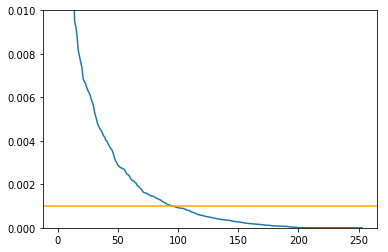

In [24]:
# Investigate the variance accounted for by each principal component.
accounted_variance = pca.explained_variance_ratio_

plt.plot(accounted_variance)
plt.axhline(0.001,color='orange')
plt.ylim(0,0.01)
plt.show()

In [25]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=100)
train_df_scaled_pca = pca.fit_transform(train_df_scaled)


### Discussion 2.2: Perform Dimensionality Reduction

The plot of the explained variance ratios shows, that at around 90 to 100 the marginal increase of explained variance of an additional component becomes less than 0.1 per cent. Therefore, I decided to only include the 100 most important features in the analysis to reduce the complexity of the model, while only losing a marginal amount of information.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [26]:
# Definition of the function to map weights for principal components to corresponding feature names and printing the
# linked values, sorted by weight

def show_ith_pcomponent(pca_object=pca,ith_component=0,labels=train_df.columns,min_abs_value=0.5):
    pcomponents = pca_object.components_[ith_component]
    labels_sorted = labels[np.argsort(pcomponents)]
    pcomponents_sorted = pcomponents[np.argsort(pcomponents)]

    output_series = pd.Series(pcomponents_sorted)
    output_series.index = labels_sorted
    
    max_abs_value = max(abs(output_series))
    
    cropped_output_series = output_series[abs(output_series)>=min_abs_value*max_abs_value]
    
    return cropped_output_series

In [27]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

print(show_ith_pcomponent(ith_component=0))

LP_LEBENSPHASE_GROB_0.0   -0.233486
LP_LEBENSPHASE_FEIN_0.0   -0.233340
LP_FAMILIE_FEIN_0.0       -0.233328
LP_FAMILIE_GROB_0.0       -0.233328
LP_STATUS_FEIN_5.0        -0.231768
NATIONALITAET_KZ_0        -0.226466
VERS_TYP_-1               -0.226052
SHOPPER_TYP_-1            -0.226052
GFK_URLAUBERTYP_5.0       -0.223815
FINANZTYP_4               -0.218677
CJT_GESAMTTYP_6.0         -0.208085
LP_STATUS_GROB_2.0        -0.202844
ZABEOTYP_3                -0.140699
SEMIO_REL                 -0.120245
LP_FAMILIE_FEIN_1.0        0.130359
LP_FAMILIE_GROB_1.0        0.130359
SEMIO_VERT                 0.161837
HEALTH_TYP                 0.162254
VERS_TYP_1                 0.169637
NATIONALITAET_KZ_1         0.200157
dtype: float64


In [28]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(show_ith_pcomponent(ith_component=1))

VERS_TYP_-1               -0.207583
SHOPPER_TYP_-1            -0.207583
NATIONALITAET_KZ_0        -0.207456
FINANZTYP_4               -0.197359
CAMEO_DEU_2015_3A         -0.156214
LP_FAMILIE_GROB_1.0       -0.145385
LP_FAMILIE_FEIN_1.0       -0.145385
LP_STATUS_GROB_1.0        -0.141604
CAMEO_DEUG_2015_3         -0.138508
ZABEOTYP_3                -0.133560
FINANZ_ANLEGER            -0.125220
VERS_TYP_1                 0.137141
SEMIO_VERT                 0.145414
HEALTH_TYP                 0.154595
LP_STATUS_GROB_2.0         0.190342
NATIONALITAET_KZ_1         0.190512
CJT_GESAMTTYP_6.0          0.207022
GFK_URLAUBERTYP_5.0        0.207068
LP_STATUS_FEIN_5.0         0.222415
LP_LEBENSPHASE_FEIN_0.0    0.224853
LP_LEBENSPHASE_GROB_0.0    0.226572
LP_FAMILIE_GROB_0.0        0.233962
LP_FAMILIE_FEIN_0.0        0.233962
dtype: float64


In [29]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(show_ith_pcomponent(ith_component=2))

LP_FAMILIE_GROB_5.0       -0.226665
SEMIO_FAM                 -0.184812
LP_STATUS_GROB_1.0         0.178796
LP_LEBENSPHASE_GROB_2.0    0.188005
LP_FAMILIE_FEIN_1.0        0.335760
LP_FAMILIE_GROB_1.0        0.335760
ANREDE_KZ                  0.345831
dtype: float64


### Discussion 2.3: Interpret Principal Components

The principal component analysis shows, that the features are mostly associated, as one would expect. So for example "LP_LEBENSPHASE_FEIN" and "LP_LEBENSPHASE_GROB" are closely related. As the suffixes GROB and FEIN indicate that these features are super- and sub-categories, this is no surprise. However, the PCA also reveals surprising relations! E.g. according to the first principal, people with a more german sounding name are more likely to be social-security focused when it comes to insurances. Furthermore, according to the second principal component, people that are defined as "nature fans" (in terms of vacations). Lastly, according to the third principal component, women are more likely to be associated with the family status single

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [13]:
# Over a number of different cluster counts...
def elbow_test(min_clusters=1,max_clusters=30,dataset=train_df_scaled_pca):
    
    scores = []
    # run k-means clustering on the data and...
    for clusters in range(min_clusters,max_clusters):
        kmeans = KMeans(n_clusters=clusters,n_jobs=-1)
        kmeans.fit(dataset)
        yhat = kmeans.predict(dataset)
    # compute the average within-cluster distances.
        scores.append(kmeans.score(dataset,yhat)*(-1))
        
    plt.plot(scores)
    plt.xticks(list(range(min_clusters,max_clusters)))
    plt.show()    

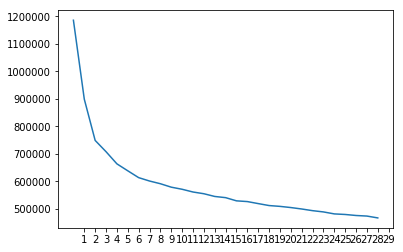

In [27]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
elbow_test()


In [14]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
optimal_amount_of_clusters = 6

kMeans_final = KMeans(n_clusters = optimal_amount_of_clusters,n_jobs=-1)
yhat_general = kMeans_final.fit_predict(train_df_scaled_pca)

### Discussion 3.1: Apply Clustering to General Population

In the above plot, one can see, that after six clusters the marginal decrease of intra-cluster distance becomes relatively constant, whhich is why I chose to use six clusters. However, given the large amount of features and the subsequent results, one could argue that more clusters would also be appropriate.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [15]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')

In [16]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customer_df = clean_data(customers)
pca_customer = PCA(n_components=100)
scaler_customer = MinMaxScaler()
customer_df_processed = make_pipeline(scaler_customer,pca_customer).fit_transform(customer_df)
yhat_customers = kMeans_final.predict(customer_df_processed)

print(customer_df_processed.shape)
print(customer_df.shape)

(55044, 100)
(55044, 254)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [17]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

yhat_general_dist = np.empty((len(np.unique(yhat_general)),1))
for i,value in enumerate(np.unique(yhat_general)):
    yhat_general_dist[i]=np.mean(yhat_general==value)
    
yhat_customers_dist = np.empty((len(np.unique(yhat_customers)),1))
for i,value in enumerate(np.unique(yhat_customers)):
    yhat_customers_dist[i]=np.mean(yhat_customers==value)
    
delta = yhat_customers_dist/yhat_general_dist
    
labels = list(np.unique(yhat_general))

comparison_result = pd.DataFrame(np.column_stack((yhat_customers_dist,yhat_general_dist,delta)),columns=['Customer Population','General Population','Delta'],index=labels)
comparison_result

,Customer Population,General Population,Delta
0,0.744404,0.406017,0.338388
1,0.102663,0.259160,-0.156496
2,0.028741,0.103893,-0.075152
3,0.029068,0.101435,-0.072368
4,0.046599,0.086079,-0.039480
5,0.048525,0.043417,0.005108


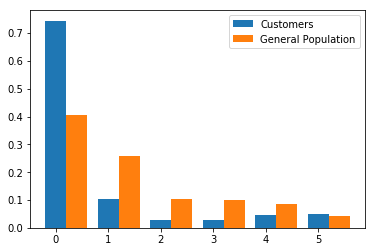

In [18]:
# Visually inspect differences in distributions
# It is apparent, that cluster 2 is massively overrepresented in the customer data, and that cluster 1,3 and 4 are
# significantly underrepresented in the customer data
fig, ax = plt.subplots()

width = 0.4
p1 = ax.bar(x=np.arange(6),height=comparison_result['Customer Population'],width=width)
p2 = ax.bar(x=np.arange(6)+width,height=comparison_result['General Population'],width=width)
ax.legend(['Customers','General Population'])

ax.autoscale_view()
plt.show()

cluster_of_overrepresentation = comparison_result.loc[:,'Delta'].idxmax()
cluster_of_underrepresentation = comparison_result.loc[:,'Delta'].idxmin()

In [19]:
# Reverse Engineer the customer data frame

re_customer_matrix = make_pipeline(scaler_customer,pca_customer).inverse_transform(customer_df_processed)
re_customer_df = pd.DataFrame(re_customer_matrix,columns=customer_df.columns)
re_customer_df['Cluster'] = yhat_customers
re_customer_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_LEBENSPHASE_GROB_8.0,LP_LEBENSPHASE_GROB_9.0,LP_LEBENSPHASE_GROB_10.0,LP_LEBENSPHASE_GROB_11.0,LP_LEBENSPHASE_GROB_12.0,bdec,movement,wealth,household_type,Cluster
0,4.010281,1.000170,5.061682,1.033999,5.030574,1.252382,2.696808,2.021445,-0.001711,0.946226,...,0.004224,-0.000216,-0.000768,-0.000480,0.001756,1952.112497,-0.001711,1.005854,4.019954,4
1,3.040194,2.000314,3.878780,2.152941,4.093901,3.396935,2.796903,1.111158,0.003239,1.996156,...,-0.004869,-0.016417,0.012511,-0.005098,-0.001044,1974.895377,0.003239,1.070206,4.082927,3
2,1.008880,1.999951,2.997540,3.997835,3.001868,4.994970,4.994501,3.003306,-0.000262,-1.000598,...,-0.000063,-0.000876,0.000372,0.000042,0.000300,1950.095698,-0.000262,1.000145,4.001721,0
3,2.988250,2.000012,3.004762,4.001476,2.993989,5.005245,5.011067,2.992925,0.000147,-1.006189,...,0.000377,0.001149,-0.000772,-0.000036,-0.000465,1949.865322,0.000147,0.999630,3.998896,0
4,1.998565,1.999981,3.001151,3.999656,2.997929,5.000108,5.002784,2.998115,-0.000058,-1.003394,...,0.000157,0.000136,-0.000200,0.000003,-0.000083,1949.980510,-0.000058,0.999887,4.000308,0


In [54]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
re_customer_df.groupby('Cluster').mean().idxmax()
overrepresented_results = pd.DataFrame(re_customer_df.groupby('Cluster').mean().idxmax(),columns=['Highest representation'])
overrepresented_results['Representation'] = re_customer_df.groupby('Cluster').mean().max()

overrepresented_results.loc[overrepresented_results['Highest representation']==cluster_of_overrepresentation]

,Highest representation,Representation
ANREDE_KZ,2,1.536428
FINANZ_SPARER,2,4.000319
FINANZ_ANLEGER,2,5.000197
SEMIO_FAM,2,6.000656
SEMIO_KRIT,2,7.000427
SEMIO_DOM,2,6.000846
SEMIO_KAEM,2,5.999036
BALLRAUM,2,6.000227
GEBAEUDETYP_RASTER,2,4.000098
KKK,2,3.000082


In [55]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# The most underrepresented cluster in the customer data seems to be cluster 4, so I will investigate that.
re_customer_df.groupby('Cluster').mean().idxmax()
overrepresented_results = pd.DataFrame(re_customer_df.groupby('Cluster').mean().idxmax(),columns=['Lowest representation'])
overrepresented_results['Representation'] = re_customer_df.groupby('Cluster').mean().max()

overrepresented_results.loc[overrepresented_results['Lowest representation']==cluster_of_underrepresentation]

,Highest representation,Representation
SEMIO_MAT,4,5.065553
SEMIO_VERT,4,6.385212
SEMIO_KULT,4,4.707559
SEMIO_TRADV,4,3.391454
SOHO_KZ,4,0.011505
ANZ_PERSONEN,4,2.697403
ANZ_TITEL,4,0.026940
KONSUMNAEHE,4,3.270982
KBA05_GBZ,4,4.071855
INNENSTADT,4,4.659435


### Discussion 3.3: Compare Customer Data to Demographics Data

As there are a lot of categories that are the most pronounced in the aforementioned clusters and some of those features do not have a logical interpretation for the project at hand, I will focus on just a few of the characteristics of the investigated clusters.
Cluster 2 is overrepresented in the customer data: 
- Women are a bit overrepresented in this cluster. The logical conclusion would be, that women are more likely to become customers. However, as the overrepresentation is barely statistically significant, this could also just be a coincidence.
- People in cluster 2 have the lowest tendency to save money (derived from the ordinal feature "FINANZ_SPARER" being the highest (on average) in cluster 2). Therefore, less frugal persons are more likely to become customers.
- People in cluster 2 are the least likely to to have a higher affinity to investment products (derived similarly to the aforementioned conclusion, but with the feature "FINANZ_ANLEGER"). Therefore, people with no or very little tendency to invest surplus capital are more likely to become customers.
- According to the "SEMIO_FAM" feature, people in cluster 2 have a rather low affinity to their family.
- According to the "SEMIO_KRIT" feature, people in cluster 2 have a rather low affinity to critical thinking. (I do wonder how that feature was derived in the first place).
- According to the "SEMIO_DOM" feature, people in cluster 2 have a rather low affinity to having a dominant personality.
- People in cluster 2 seem to be live rather far away from the next urban center (50-100km on average)
- People in cluster 2 seem to be most likely to be part of the "established middle class."

Other features can be interpreted accordingly.


Cluster 4 is underrepresented in the customer data:
- According to the "LP_LEBENSPHASE_FEIN" feature, people in cluster 2 have a tendency to live in multiperson households with the notable exception of people of higher age in multiperson households. That means middle aged and younger individuals from multiperson households are less likely to become customers.
- People in cluster 4 also have the highest number of cars in their ZIP-code areas, which can be an indicator for individuals coming from wealthier ZIP-code areas being less likely to become customers.
- According to "KBA05_GBZ" people who live in areas with a higher building density are underrepresented in the data, which supports the finding, that people that are far away  from the next urban center are overrepresented in the customer data.

Other features can be interpreted accordingly.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.